# Gaussian elimination to expose leaves

**Idea**: $b$-reduction as a method of exposing leaves has 2 limitations:
* Arbitrariness on the choice of $b$
* No control on how the compression rate changes

**Proposal**: 
* Build a graph with no leaves
* Instead of removing factors, do Gaussian elimination on the parity-check matrix which defines the graph
* Build a new graph from the matrix resulting after Gaussian elimination

The new graph will have some leaves (here we compute how many) while the space of solutions, hence the rate, is left untouched.

In [119]:
using Printf, Plots, ProgressMeter
include("../code/headers.jl")
include("../code/SimulationNEW.jl")

LoadError: LoadError: LoadError: invalid redefinition of type SAResults
in expression starting at /home/crotti/sourcecoding/code/simanneal.jl:30
in expression starting at /home/crotti/sourcecoding/code/headers.jl:8

## How many leaves does Gaussian elimination expose?

At fixed rate $R=0.3$, let $n$ increase

In [43]:
const q = 2
nvals = Int.(floor.(10 .^(LinRange(1,3.1,7))))
R = 0.3
mvals = ceil.(Int, nvals.*(1-R))
niter = 50
randseed = 1234
variable_degrees = [[Dict{Int64,Float64}() for it in 1:niter] for n in 1:length(nvals)]
nleaves = [zeros(Int, niter) for n in 1:length(nvals)];

For each value of $n$, sample 50 random graphs and store the degree profiles to make some statistics

In [ ]:
for (i,n) in enumerate(nvals)
    println("n=$n. $i of $(length(nvals))")
    @showprogress for it in 1:niter
        lm = LossyModel(q, n, mvals[i], randseed=randseed+niter*i+it)
        gfref!(lm)
        nleaves[i][it] = nvarleaves(lm.fg)
        variable_degrees[i][it] = vardegrees_distr(lm.fg)
    end
end

Plot the average number of leaves as $n$ increases

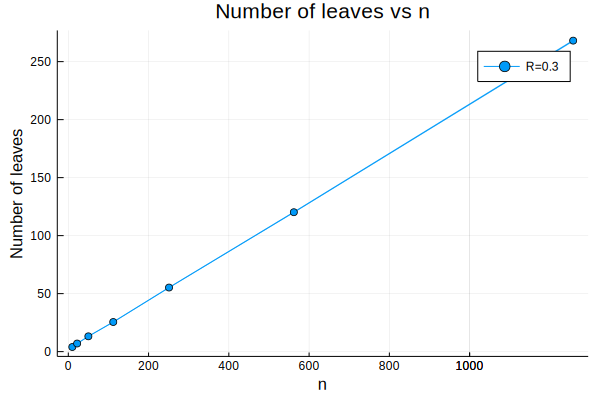

In [46]:
avg_leaves = [mean(nleaves[j]) for j in eachindex(nvals)]
sd_leaves = [std(nleaves[j])/sqrt(niter) for j in eachindex(nvals)]
plt = Plots.plot(nvals, avg_leaves, markershape=:circle, label="R=$R", ribbon=sd_leaves)
xlabel!("n")
ylabel!("Number of leaves")
title!("Number of leaves vs n")

In [47]:
slope = nvals\avg_leaves
@printf("Slope: %.2f\n", slope)

Slope: 0.21


## Estimate the proportionality constant between number of leaves and n as R varies

Repeat the procedure at the beginning of this notebook, for different rates.
For each rate, fit the slope from the $n$ vs $N_{leaves}$ plot

In [26]:
nvals = Int.(floor.(10 .^(LinRange(1,2.7,7))))
Rvals = 0.1:0.05:0.7
mvals = ceil.(Int, nvals.*(1-R))
niter = 50
randseed = 1234
nleaves_new = [[zeros(Int, niter) for n in 1:length(nvals)] for R in Rvals];

In [ ]:
for (r,R) in enumerate(Rvals)
    println("### R=$R. $r of $(length(Rvals))")
    mvals = ceil.(Int, nvals.*(1-R))
    @showprogress for (i,n) in enumerate(nvals)
        for it in 1:niter
            lm = LossyModel(q, n, mvals[i], randseed=randseed+niter*i+it)
            gfref!(lm)
            nleaves_new[r][i][it] = nvarleaves(lm.fg)
            variable_degrees[i][it] = vardegrees_distr(lm.fg)
        end
    end
end

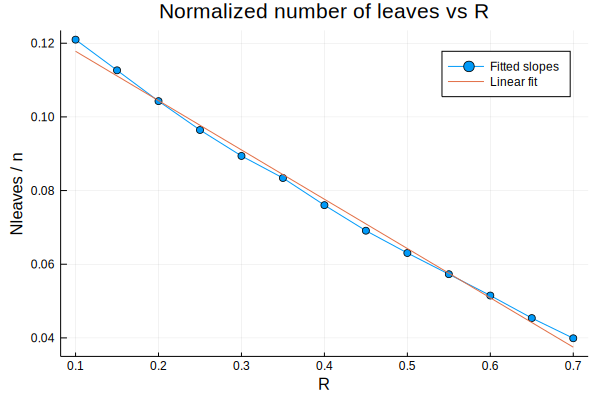

In [100]:
avg_leaves_new = [[mean(nleaves_new[r][j]) for j in eachindex(nvals)] for r in eachindex(Rvals)]
slopes = [nvals\avg_leaves_new[r] for r in eachindex(Rvals)]

plt = Plots.plot(Rvals, slopes, markershape=:circle, label="Fitted slopes")
xlabel!("R")
ylabel!("Nleaves / n")
title!("Normalized number of leaves vs R")

X = [Rvals ones(length(Rvals))]
Y = slopes
z = X\Y
Plots.plot!(plt, collect(0.1:0.01:0.7), z[1] .* collect(0.1:0.01:0.7) .+ z[2], label="Linear fit")

## Compare with b-reduction in terms of compression performance

Run Max-Sum on graphs with $b$-reduction first and then with Gaussian elimination. Same size, same compression rate

In [113]:
n = 2000
mvals = reverse(Int.(round.(n*(0.2:0.15:0.95))))
niter = 150
sims_b = Vector{Simulation{MS}}(undef, length(mvals))
sims_gauss = Vector{Simulation{MS}}(undef, length(mvals))
ms = MS(maxiter=100, gamma=5e-3);

In [117]:
for (j,m) in enumerate(mvals)
    println("##### R = ", round(1-m/n, digits=2), ". ",
        "$j of $(length(mvals)) #####")
#     b = ceil(Int, n/2.6*(z[1]*(1-m/n)+z[2]))
    b = 100
    sims_b[j] = Simulation(q, n, m, ms, b=b, niter=niter, randseed=randseed+200*j, 
        verbose=true, showprogress=false)
#     sims_gauss[j] = Simulation(q, n, m, ms, b=0, niter=niter, gauss_elim=true,
#         randseed=randseed+200*j, verbose=true, showprogress=false)
end

##### R = 0.05. 1 of 6 #####
# Finished iter 1 of 50: C after 12 iters, 1 trials. Parity 0. Distortion 0.45.
# Finished iter 2 of 50: C after 25 iters, 1 trials. Parity 0. Distortion 0.45.
# Finished iter 3 of 50: C after 13 iters, 1 trials. Parity 0. Distortion 0.45.
# Finished iter 4 of 50: C after 20 iters, 1 trials. Parity 0. Distortion 0.47.
# Finished iter 5 of 50: C after 14 iters, 1 trials. Parity 0. Distortion 0.43.
# Finished iter 6 of 50: C after 16 iters, 1 trials. Parity 0. Distortion 0.45.
# Finished iter 7 of 50: C after 23 iters, 1 trials. Parity 0. Distortion 0.44.
# Finished iter 8 of 50: C after 17 iters, 1 trials. Parity 0. Distortion 0.46.
# Finished iter 9 of 50: C after 15 iters, 1 trials. Parity 0. Distortion 0.43.
# Finished iter 10 of 50: C after 19 iters, 1 trials. Parity 0. Distortion 0.45.
# Finished iter 11 of 50: C after 20 iters, 1 trials. Parity 0. Distortion 0.44.
# Finished iter 12 of 50: C after 19 iters, 1 trials. Parity 0. Distortion 0.42.
# Finish

# Finished iter 2 of 50: C after 13 iters, 1 trials. Parity 0. Distortion 0.11.
# Finished iter 3 of 50: C after 17 iters, 1 trials. Parity 0. Distortion 0.10.
# Finished iter 4 of 50: C after 7 iters, 2 trials. Parity 0. Distortion 0.11.
# Finished iter 5 of 50: C after 10 iters, 1 trials. Parity 0. Distortion 0.10.
# Finished iter 6 of 50: C after 9 iters, 1 trials. Parity 0. Distortion 0.11.
# Finished iter 7 of 50: C after 9 iters, 1 trials. Parity 0. Distortion 0.11.
# Finished iter 8 of 50: C after 9 iters, 1 trials. Parity 0. Distortion 0.11.
# Finished iter 9 of 50: C after 10 iters, 1 trials. Parity 0. Distortion 0.10.
# Finished iter 10 of 50: C after 12 iters, 1 trials. Parity 0. Distortion 0.11.
# Finished iter 11 of 50: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 12 of 50: C after 5 iters, 1 trials. Parity 0. Distortion 0.10.
# Finished iter 13 of 50: C after 13 iters, 1 trials. Parity 0. Distortion 0.12.
# Finished iter 14 of 50: C after 11 ite

Plot the results

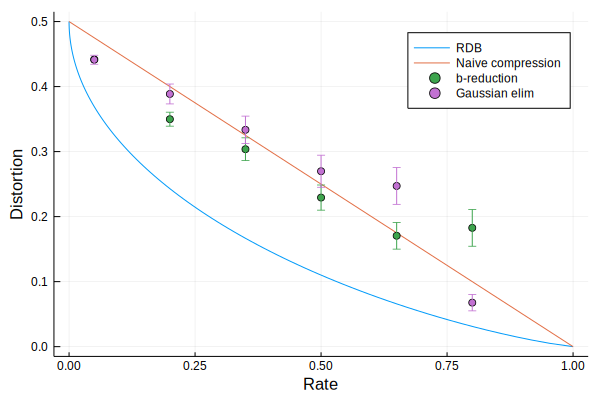

In [118]:
pl = plot(sims_b, label="b-reduction")
plot!(pl, sims_gauss, label="Gaussian elim")